Code for adversarial training

In [114]:
!pip install PyWavelets


In [115]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [116]:
! mv /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3 /content

mv: cannot move '/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3' to '/content/3': Directory not empty


In [117]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pywt

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.utils import shuffle


In [ ]:
# Loading the images
def load_balanced_images_from_directory(real_dir, fake_dir, label_real=0, label_fake=1, image_size=(32, 32), max_samples=50000):
    real_images, fake_images = [], []

    # Load REAL images
    real_filenames = os.listdir(real_dir)
    random.shuffle(real_filenames)
    for filename in real_filenames[:max_samples]:  
        img_path = os.path.join(real_dir, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, image_size)  # Resize image
            image = image / 255.0  # Normalize
            real_images.append(image)

    # Load FAKE images
    fake_filenames = os.listdir(fake_dir)
    random.shuffle(fake_filenames)
    for filename in fake_filenames[:max_samples]:  
        img_path = os.path.join(fake_dir, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, image_size)  # Resize image
            image = image / 255.0  # Normalize
            fake_images.append(image)


    images = np.array(real_images + fake_images)
    labels = np.array([label_real] * len(real_images) + [label_fake] * len(fake_images))

    return images, labels

# Extract wavelet features from an image
def extract_wavelet_features(image, wavelet='bior1.3'):
    coeffs2 = pywt.dwt2(image, wavelet)
    LL, (LH, HL, HH) = coeffs2  # Decompose into 4 sub-bands (LL, LH, HL, HH)

    # Flatten each coefficient and concatenate them into a feature vector
    LL_flat = LL.flatten()
    LH_flat = LH.flatten()
    HL_flat = HL.flatten()
    HH_flat = HH.flatten()

    features = np.concatenate([LL_flat, LH_flat, HL_flat, HH_flat])

    return features

# Extract wavelet features and stack them for multiple images
def extract_features_and_stack(images, wavelet='bior1.3'):
    all_features = []
    for image in images:
        features = extract_wavelet_features(image, wavelet)
        all_features.append(features)

    stacked_features = np.vstack(all_features)
    return stacked_features

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1)):
    """
    A simple residual block with a skip connection.
    """
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Adding the skip connection (residual)
    x = layers.add([x, shortcut])

    return x

def create_resnet_hybrid_model(input_shape_cnn, input_shape_wavelet):
    """
    A simpler CNN + wavelet hybrid model with ResNet-like architecture and regularization.
    """
    # CNN Branch (ResNet-like)
    cnn_input = layers.Input(shape=input_shape_cnn)
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(cnn_input)
    x = layers.BatchNormalization()(x)

    
    for _ in range(2):  
        x = residual_block(x, 16)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    for _ in range(2):  
        x = residual_block(x, 32)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    for _ in range(2):  
        x = residual_block(x, 64)

    x = layers.MaxPooling2D((2, 2))(x)

    cnn_output = layers.Flatten()(x)

    # Wavelet Branch (Fully connected)
    wavelet_input = layers.Input(shape=input_shape_wavelet)
    wavelet_output = layers.Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(wavelet_input)
    wavelet_output = layers.BatchNormalization()(wavelet_output)
    wavelet_output = layers.Dropout(0.3)(wavelet_output)
    wavelet_output = layers.Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(wavelet_output)

    # Combine CNN and wavelet features
    combined = layers.concatenate([cnn_output, wavelet_output])

    # Fully connected layers with dropout
    combined_output = layers.Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(combined)
    combined_output = layers.Dropout(0.3)(combined_output)
    combined_output = layers.Dense(1, activation='sigmoid')(combined_output)  # Sigmoid for binary classification

    # Final model
    model = Model(inputs=[cnn_input, wavelet_input], outputs=combined_output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [120]:
def split_data(images, wavelet_features, labels, train_split=0.8):
    # Shuffle the data
    images, wavelet_features, labels = shuffle(images, wavelet_features, labels, random_state=42)

    # Split the data into training and validation sets
    split_idx = int(len(images) * train_split)

    # Training data
    train_images = images[:split_idx]
    train_wavelet = wavelet_features[:split_idx]
    train_labels = labels[:split_idx]

    # Validation data
    val_images = images[split_idx:]
    val_wavelet = wavelet_features[split_idx:]
    val_labels = labels[split_idx:]

    return train_images, val_images, train_wavelet, val_wavelet, train_labels, val_labels


In [ ]:
# FGSM method 
def generate_adversarial_example(model, image, wavelet_features, label, epsilon=0.1):
    """
    Generate adversarial example for the CNN input using FGSM.
    :param model: Trained hybrid model
    :param image: Single image (CNN input)
    :param wavelet_features: Corresponding wavelet features
    :param label: True label for the image
    :param epsilon: Perturbation factor
    :return: Adversarial example for the CNN input
    """
    # Convert inputs to tensors
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    wavelet_features = tf.convert_to_tensor(wavelet_features, dtype=tf.float32)
    label = tf.convert_to_tensor(label, dtype=tf.float32)

    # Reshape label to match output shape (batch size of 1, with 1 prediction per batch)
    label = tf.reshape(label, (1, 1))  # Model expects shape (batch_size, 1)

    # Enable gradient calculation
    image = tf.Variable(image)  # Make the image trainable

    with tf.GradientTape() as tape:
        tape.watch(image)  # Track gradients for the image
        prediction = model([tf.expand_dims(image, axis=0), tf.expand_dims(wavelet_features, axis=0)])
        loss = tf.keras.losses.binary_crossentropy(label, prediction)  # Compute loss

    # Compute the gradient of the loss w.r.t. the image
    gradient = tape.gradient(loss, image)

    # Generate adversarial perturbation
    perturbation = epsilon * tf.sign(gradient)

    # Create adversarial example by adding perturbation to the image
    adversarial_image = image + perturbation

    # Clip pixel values to ensure valid range [0, 1]
    adversarial_image = tf.clip_by_value(adversarial_image, 0.0, 1.0)


    return adversarial_image.numpy()  # Return as numpy array


In [122]:
# Enable mixed precision for faster training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Leverages GPU tensor core

In [ ]:
# Adversarial Training

def train_with_adversarial(model, train_images, train_wavelet, train_labels, val_images, val_wavelet, val_labels, epochs=5, batch_size=64, epsilon=0.1):
    """
    Train the hybrid model with adversarial examples.
    :param model: Hybrid model
    :param train_images: Training images for CNN branch
    :param train_wavelet: Wavelet features for training
    :param train_labels: Training labels
    :param val_images: Validation images for CNN branch
    :param val_wavelet: Wavelet features for validation
    :param val_labels: Validation labels
    :param epochs: Number of training epochs
    :param batch_size: Training batch size
    :param epsilon: Perturbation factor for adversarial examples
    """
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Shuffle the data
        indices = np.random.permutation(len(train_images))
        train_images = train_images[indices]
        train_wavelet = train_wavelet[indices]
        train_labels = train_labels[indices]

        # Process data in batches
        for i in range(0, len(train_images), batch_size):
            # Select the batch
            batch_images = train_images[i:i + batch_size]
            batch_wavelet = train_wavelet[i:i + batch_size]
            batch_labels = train_labels[i:i + batch_size]

            # Generate adversarial examples for the batch
            adv_images = np.array([
                generate_adversarial_example(model, img, wavelet, lbl, epsilon)
                for img, wavelet, lbl in zip(batch_images, batch_wavelet, batch_labels)
            ])

            with tf.GradientTape() as tape:
                # Compute predictions for clean and adversarial inputs
                clean_output = model([batch_images, batch_wavelet])
                adv_output = model([adv_images, batch_wavelet])

                # Compute loss for both clean and adversarial inputs
                clean_loss = loss_fn(batch_labels, clean_output)
                adv_loss = loss_fn(batch_labels, adv_output)

                # Combine the losses
                total_loss = clean_loss + adv_loss

            # Update model weights
            grads = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Evaluate on validation data
        val_loss, val_acc = model.evaluate([val_images, val_wavelet], val_labels, verbose=0)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


In [124]:
# Load images from directories
real_dir = '/content/3/train/REAL'
fake_dir = '/content/3/train/FAKE'
images, labels = load_balanced_images_from_directory(real_dir, fake_dir)

# Extract wavelet features
stacked_wavelet_features = extract_features_and_stack(images)

# Split data into train and validation sets
train_images, val_images, train_wavelet, val_wavelet, train_labels, val_labels = split_data(images, stacked_wavelet_features, labels)

# Reshape images for CNN input
train_images = train_images.reshape(train_images.shape[0], 32, 32, 1)
val_images = val_images.reshape(val_images.shape[0], 32, 32, 1)

# Define input shapes
input_shape_cnn = train_images.shape[1:]
input_shape_wavelet = (stacked_wavelet_features.shape[1],)

# Create the hybrid model
model = create_resnet_hybrid_model(input_shape_cnn, input_shape_wavelet)




In [ ]:
# Checking how the adversarial FGSM function performs
import time
start_time = time.time()
_ = generate_adversarial_example(model, train_images[0], train_wavelet[0], train_labels[0], epsilon=0.1)
print(f"Adversarial example generation took {time.time() - start_time} seconds")


Adversarial example generation took 0.13107919692993164 seconds


In [ ]:
# Compiling model and setting its hyperparameters

def train_with_adversarial(model, train_images, train_wavelet, train_labels,
                           val_images, val_wavelet, val_labels,
                           epochs=5, batch_size=64, epsilon=0.1):
    # Prepare adversarial examples here (ensure this step is correct in your implementation)

    # Compile the model (if not already compiled)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Combine wavelet features with images (adjust based on your architecture)
    train_data = [train_images, train_wavelet]
    val_data = [val_images, val_wavelet]

    # Train the model and capture the history
    history = model.fit(
        train_data, train_labels,
        validation_data=(val_data, val_labels),
        epochs=epochs,
        batch_size=batch_size
    )

    return history


In [ ]:
#Training 

history = train_with_adversarial(
    model,
    train_images,
    train_wavelet,
    train_labels,
    val_images,
    val_wavelet,
    val_labels,
    epochs=5,
    batch_size=64,
    epsilon=0.1,
)


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.8306 - loss: 0.4821 - val_accuracy: 0.9165 - val_loss: 0.2343
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9207 - loss: 0.2296 - val_accuracy: 0.9273 - val_loss: 0.2068
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9322 - loss: 0.2005 - val_accuracy: 0.9312 - val_loss: 0.2006
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9370 - loss: 0.1860 - val_accuracy: 0.8850 - val_loss: 0.2969
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9428 - loss: 0.1739 - val_accuracy: 0.9420 - val_loss: 0.1661


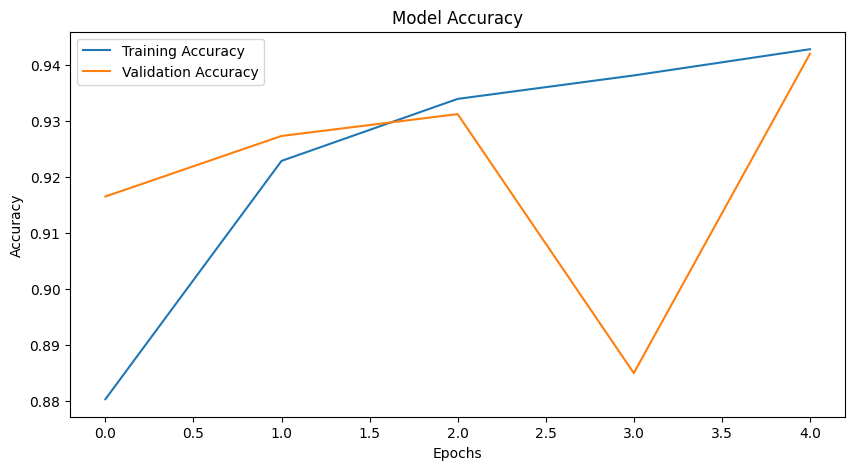

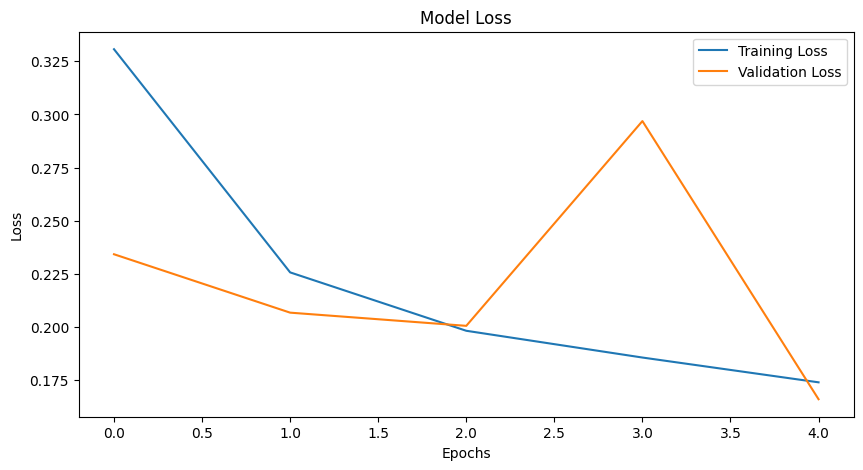

In [129]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Testing on the CIFAKE's test dataset

In [130]:
# Define the test directories
test_real_dir = '/content/3/test/REAL'
test_fake_dir = '/content/3/test/FAKE'

# Load test images and labels
test_images, test_labels = load_balanced_images_from_directory(test_real_dir, test_fake_dir)

# Extract wavelet features for the test set
test_wavelet_features = extract_features_and_stack(test_images)

# Reshape images for CNN input
test_images = test_images.reshape(test_images.shape[0], 32, 32, 1)


In [131]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([test_images, test_wavelet_features], test_labels, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9408 - loss: 0.1651
Test Loss: 0.1658, Test Accuracy: 0.9427


In [137]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on test data
test_predictions = model.predict([test_images, test_wavelet_features])
test_predictions = (test_predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Print the classification report
print(classification_report(test_labels, test_predictions, target_names=["REAL", "FAKE"]))


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
              precision    recall  f1-score   support

        REAL       0.95      0.94      0.94     10000
        FAKE       0.94      0.95      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



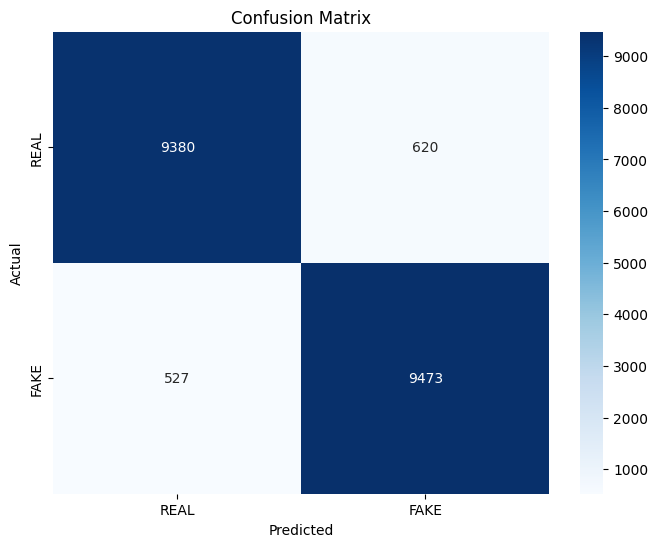

In [138]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "FAKE"], yticklabels=["REAL", "FAKE"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Testing on CIFar-10 dataset(all real images)

In [147]:
# Preprocessing Pipline
def extract_wavelet_features(image, wavelet='bior1.3'):
    coeffs2 = pywt.dwt2(image, wavelet)
    LL, (LH, HL, HH) = coeffs2  # Decompose into 4 sub-bands (LL, LH, HL, HH)

    # Flatten each coefficient and concatenate them into a feature vector
    LL_flat = LL.flatten()
    LH_flat = LH.flatten()
    HL_flat = HL.flatten()
    HH_flat = HH.flatten()

    features = np.concatenate([LL_flat, LH_flat, HL_flat, HH_flat])

    return features

def extract_features_and_stack(images, wavelet='bior1.3'):
    all_features = []
    for image in images:
        features = extract_wavelet_features(image, wavelet)
        all_features.append(features)

    stacked_features = np.vstack(all_features)
    return stacked_features

# Load CIFAR-10 data
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

# CIFAR-10 images are RGB, but the model expects grayscale images, so we need to convert them.
def rgb_to_grayscale(images):
    return np.dot(images[...,:3], [0.2989, 0.5870, 0.1140])  # Convert RGB to grayscale

# Convert CIFAR-10 test data to grayscale
test_images_grayscale = rgb_to_grayscale(test_data)

# Resize CIFAR-10 test images to match the expected input size (32x32)
test_images_resized = np.array([cv2.resize(image, (32, 32)) for image in test_images_grayscale])

# Normalize the pixel values to [0, 1]
test_images_resized = test_images_resized / 255.0

# Extract wavelet features for the test images
stacked_wavelet_features_test = extract_features_and_stack(test_images_resized)

# Reshape CNN input (test images) and wavelet input (test features)
cnn_input_images_test = test_images_resized.reshape(test_images_resized.shape[0], 32, 32, 1)  # Add channel dimension for CNN
wavelet_input_features_test = stacked_wavelet_features_test  # These are the wavelet features already stacked

# Perform predictions using the model
test_predictions = model.predict([cnn_input_images_test, wavelet_input_features_test])

# Convert predictions to binary (REAL: 0, FAKE: 1)
test_predictions_binary = (test_predictions > 0.5).astype(int)

count=0
for i in test_predictions_binary:
    if i==0:
        count=count+1

print("Accuracy:",count/len(test_images_grayscale))


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Accuracy: 0.9306
